# This is the third step in project.

Motivaton: To Train the baseline model.

Final output: Accuracy and feature importance of baseline model.

In [1]:
# import required libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
# file paths
ROOT = os.path.join(os.getcwd(), 'Statsbomb_data\open-data-master')
DATA = os.path.join(ROOT, 'data')
FINAL_DF = os.path.join(ROOT,'final_dataframes')

# Import final dataframe from data_prep_2

In [4]:
''' Import the final dataset prepared in data_prep_2 file. I will use this dataset to train baseline model. 

Variables:-
FINAL_DF - string - file path of all pickle files.
'''
df = pd.read_pickle(
    filepath_or_buffer=os.path.join(FINAL_DF,'final_df.pkl')
)
df.head()

,event_id,player,first_touch,open_goal,under_pressure,shot_technique,shot_body_part,statsbomb_xg,goal,aerial_shot,from_play,one_v_one
0,682270cc-4bc4-4952-8f91-d3c5a704a691,Georginio Wijnaldum,False,False,False,Normal,Right Foot,0.036399,False,True,Throw In,False
1,9f5aa3eb-3bed-4bc0-97a5-bb8444b235b9,Mohamed Salah,True,False,True,Normal,Left Foot,0.027976,False,True,Free Kick,False
2,399ac143-5f7b-4080-8c0b-3c18435d7fc1,Roberto Firmino Barbosa de Oliveira,False,False,False,Normal,Head,0.075361,False,True,Regular Play,False
3,660d9d98-46b6-4b5e-9c9a-435d63142c93,Marcelo Vieira da Silva Júnior,False,False,False,Normal,Left Foot,0.023376,False,True,Free Kick,False
4,fe6c7f60-2ff0-4077-882e-b045c8abc7c3,James Philip Milner,True,False,False,Normal,Left Foot,0.043772,False,True,Free Kick,False


# Creating a Baseline Model with Logistic Regression

### Preparing data for training

In [7]:
''' Check null values 

Variables:-
df - DataFrame - dataset for training baseline model.
'''
df.isnull().sum()

event_id          0
player            0
first_touch       0
open_goal         0
under_pressure    0
shot_technique    0
shot_body_part    0
statsbomb_xg      0
goal              0
aerial_shot       0
from_play         0
one_v_one         0
dtype: int64

In [8]:
''' Encoding all boolean features with One-hot encoding. Logistic Regression can only interpret numerical data.

Variables:-
df - DataFrame - dataset for training baseline model.
'''
encoded_df = pd.get_dummies(
    data=df,
    columns=['first_touch','open_goal','under_pressure','shot_technique','shot_body_part','goal','aerial_shot','from_play','one_v_one'],
    drop_first=True
)

In [9]:
''' Encoding all categorical features to numeric integers.

Variables:-
encoded_df - DataFrame - encoded version of dataset
'''
encoded_df['player']=encoded_df['player'].astype('category')
encoded_df['player']=encoded_df['player'].cat.codes
encoded_df.head()

,event_id,player,statsbomb_xg,first_touch_True,open_goal_True,under_pressure_True,shot_technique_Diving Header,shot_technique_Half Volley,shot_technique_Lob,shot_technique_Normal,...,aerial_shot_True,from_play_Counter,from_play_Free Kick,from_play_Goal Kick,from_play_Keeper,from_play_Kick Off,from_play_Other,from_play_Regular Play,from_play_Throw In,one_v_one_True
0,682270cc-4bc4-4952-8f91-d3c5a704a691,488,0.036399,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,9f5aa3eb-3bed-4bc0-97a5-bb8444b235b9,1029,0.027976,1,0,1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,399ac143-5f7b-4080-8c0b-3c18435d7fc1,1166,0.075361,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,660d9d98-46b6-4b5e-9c9a-435d63142c93,918,0.023376,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
4,fe6c7f60-2ff0-4077-882e-b045c8abc7c3,607,0.043772,1,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0


In [10]:
''' Dividing dataset between dependent and target variables. Here, the target variable if goal_true, which is 1 
    if the shot was converted to a goal.
    
    Variables:-
    encoded_df - DataFrame - encoded version of dataset
'''
dependent = encoded_df.drop(['goal_True'],axis=1)
target = encoded_df['goal_True']

In [11]:
''' Splitting the dataset rows in 70% training and 30% testing.

Variables:-
dependent - DataFrame - dataframe of dependent variables
target - Series - target variable column
'''
dependent_train, dependent_test, target_train, target_test = train_test_split(dependent, target, test_size = 0.3)

In [12]:
''' Training Logistic Regression model. Notice that I have removed event_id as it doesn't 
    provide any infomation, and statsbomb_xg column will be later used to compare predicted
    xG vs statsbomb xG.

Variables:-
dependent_train - DataFrame - training set
'''
baseline =  LogisticRegression(max_iter=1000)
baseline.fit(dependent_train.drop(['statsbomb_xg','event_id'],axis=1), target_train)

LogisticRegression(max_iter=1000)

# Prediction

In [18]:
''' Making prediction on test set.

Variables:-
baseline - sklearn.linear_model.LogisticRegression object - baseline model
dependent_test - test set of dependent variables
'''
predictions = baseline.predict(dependent_test.drop(['statsbomb_xg','event_id'],axis=1))
np.unique(predictions)

array([0, 1], dtype=uint8)

Logistic Regression gives a binary prediction, and both values have an associated probability. 

The probability value of class 1 is the predicted xG. I will compare that with statsbomb xG.

In [19]:
''' Fetching the probability of class 1 from predictions. This gives me the predictedd xG value.

Variables:-
baseline - sklearn.linear_model.LogisticRegression object - baseline model
dependent_test - Series - test set of dependent variables
'''
test_xG = baseline.predict_proba(dependent_test.drop(['statsbomb_xg','event_id'],axis=1))[:,1]

In [24]:
''' Measureing root mean squared error.
    Notice that I am finding error of numerical values. Hence RMSE is used. 
    
    Variables:-
    dependent_test - Series - test set of dependent variables
    test_xG - Numpy array - predicted xG value
'''
rmse = metrics.mean_squared_error(y_true=dependent_test.drop(['event_id'],axis=1)['statsbomb_xg'], y_pred=test_xG, squared=False)
print(f'ROOT MEAN SQUARED ERROR OF BASELINE MODEL: {round(rmse, 4)}')

ROOT MEAN SQUARED ERROR OF BASELINE MODEL: 0.012


In [28]:
''' Checking the classification accuracy of baseline model. 
    Here, the binary output is compared against goal_True target variable in test set 
    
    Variables:-
    baseline - sklearn.linear_model.LogisticRegression object - baseline model
    dependent_test - Series - test set of dependent variables
'''
score = baseline.score(X=dependent_test.drop(['statsbomb_xg','event_id'],axis=1), y=target_test)
print(f"Test Accuracy Score: {round(score*100,2)}%")

Test Accuracy Score: 89.12%


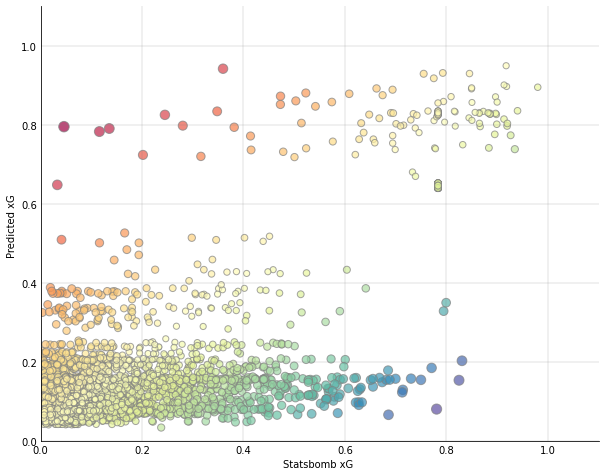

In [29]:
''' Plotting predicted xG versus statsbomb xG.

    Variables:-
    dependent_test - Series - test set of dependent variables
    test_xG - Numpy array - predicted xG value
    
'''
# calculating error between statsbomb_xg and predicted xg
error = np.subtract(
    dependent_test['statsbomb_xg'],
    test_xG
)

plt.figure(figsize=(10,8))
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.grid(
    color='gray',
    alpha=0.15,
    linewidth=1.5
)
g=plt.scatter(
    dependent_test['statsbomb_xg'],
    test_xG,
    s=(plt.rcParams['lines.markersize'] * (1+np.absolute(error))) ** 2,
    c=error,
    alpha=0.7,
    edgecolors='gray',
    cmap='Spectral'
)
g.axes.set_xlabel('Statsbomb xG ')
g.axes.set_ylabel('Predicted xG ')
g.axes.spines[['right', 'top']].set_visible(False)
g.axes.tick_params(axis=u'both', which=u'both',length=0) # taken from: https://stackoverflow.com/questions/29988241/hide-ticks-but-show-tick-labels

### Summary

The baseline model has RMSE of 0.012 and classification accuracy of 89% on test set.

However, plotting the values show that the model is still unable to predict a huge portion of xG values correctly.

Let's analyze the feature importances in the next step.

# Feature Importance

Feature importance is calculate using SHAP algorithm.

The content of this section is taken from official SHAP library documentation

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [31]:
def baseline_proba(x,baseline=baseline):
    ''' Fetch the probabilities of class 1 from baseline predictions.
    
    Variables:-
    x - Series - dependent features
    baseline - sklearn.linear_model.LogisticRegression object - baseline model
    '''
    return baseline.predict_proba(x)[:, 1]

In [33]:
''' compute the SHAP values for the baseline model.

Variables:-
dependent_train - Series - train set of dependent variables
baseline_proba - function - to calculate predicted xG
'''
background_adult = shap.maskers.Independent(dependent_train.drop(['statsbomb_xg','event_id'],axis=1), max_samples=100)
explainer = shap.Explainer(baseline_proba, background_adult)
shap_values = explainer(dependent_train.drop(['statsbomb_xg','event_id'],axis=1)[:1000])

PermutationExplainer explainer: 1001it [00:56, 17.09it/s]                         


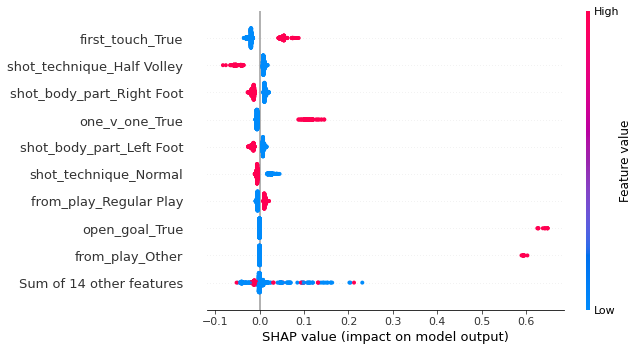

In [34]:
''' Creating a beeswarm plot to visualize feature importances 

Variables:-
shap_values - shap.Explainer object - object containing feature importance information
'''
shap.plots.beeswarm(shap_values)

### Summary

The feature importance plot indicates top features on left hand side of the plot.

Followed by a spread measure indicating their impact on model output.

We can see that no feature is contributing well. 

The last line 'Sum of 14 other features' is able to make an impact of around 0.25

The overall analysis suggests that we should include more advanced features. That's what we will do while training the improvised model.